In [3]:
import os
import pickle as pkl
import pandas as pd
import numpy as np

from pydeseq2.utils import build_design_matrix
#from pydeseq2.dds import DeseqDataSet
#from pydeseq2.default_inference import DefaultInference
#from pydeseq2.ds import DeseqStats

In [39]:
# Loading the data from package

In [101]:
# Test simulated data
#DATA_PATH = "/Users/katsiarynadavydzenka/Documents/PhD_AI/CN-aware-DGE/Python/datasets/"
#counts_df = pd.read_csv(os.path.join(DATA_PATH, "rna_counts_cnv_v2.csv"), index_col=0)
#counts_df = counts_df.T
#metadata = pd.read_csv(os.path.join(DATA_PATH, "metadata_v2.csv"), index_col=0)
#cnv = pd.read_csv(os.path.join(DATA_PATH, "cnv_v2.csv"), index_col=0)
#cnv = cnv.T

In [35]:
# Test real data
DATA_PATH = "/Users/katsiarynadavydzenka/Documents/PhD_AI/TCGA/liver/test"
counts_df = pd.read_csv(os.path.join(DATA_PATH, "rna_test_2.csv"), index_col=0)
counts_df = counts_df.T
metadata = pd.read_csv(os.path.join(DATA_PATH, "metadata_2.csv"), index_col=0)
cnv = pd.read_csv(os.path.join(DATA_PATH, "cnv_test_2.csv"), index_col=0)
cnv = cnv.T

In [37]:
from dds import pydeseq2CN_data
from inference import Inference
from def_inference import DefInference
import utils_pydeseq2CN

In [39]:
inference = DefInference(n_cpus=8)
dds = pydeseq2CN_data(
    counts=counts_df,
    metadata=metadata,
    cnv=cnv,
    design_factors="condition",
    inference=inference,
    refit_cooks=True
)

In [41]:
dds.fit_size_factors()
dds.fit_genewise_dispersions()
dds.fit_dispersion_trend()
dds.fit_dispersion_prior()
dds.fit_MAP_dispersions()
dds.fit_LFC()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 0.47 seconds.

Fitting dispersion trend curve...
... done in 0.06 seconds.

Fitting MAP dispersions...
... done in 0.53 seconds.

Fitting LFCs...
... done in 0.23 seconds.



In [55]:
#dds.obsm["size_factors"]
#dds.varm["fitted_dispersions"]
#print(
    #f"logres_prior={dds.uns['_squared_logres']}, sigma_prior={dds.uns['prior_disp_var']}"
#)
#dds.varm["MAP_dispersions"]
#dds.varm["LFC"]

In [43]:
dds.calculate_cooks()
if dds.refit_cooks:
    # Replace outlier counts
    dds.refit()

replace_mask before filtering: (34, 42)
Number of True values in replace_mask: 43
replacement_counts_trimmed shape: (15, 42)


Calculating cook's distance...
... done in 0.02 seconds.

Replacing 42 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



In [ ]:
# Statistical test

In [45]:
import dds_stat
from dds_stat import pydeseq2CN_Stats

In [47]:
# Statistical analysis
stat_res = pydeseq2CN_Stats(dds, alpha=0.05, independent_filter=True, cooks_filter=True)
stat_res.run_wald_test()

Running Wald tests...
... done in 0.20 seconds.



In [49]:
stat_res.p_values

TSPAN6    1.885400e-02
CFH       1.400779e-07
FUCA2     5.885100e-01
GCLC      2.487412e-18
LAP3      4.795186e-17
              ...     
SRD5A2    1.420640e-10
CISD3     2.057599e-04
MYO19     1.648563e-02
ACACA     8.882698e-01
EBLN3P    2.275227e-06
Length: 3945, dtype: float64

In [51]:
if stat_res.independent_filter:
    stat_res._independent_filtering()
else:
    stat_res._p_value_adjustment()

stat_res.padj

/opt/anaconda3/lib/python3.11/site-packages/pydeseq2/utils.py:1599: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta = np.linalg.lstsq(A, b)[0]


TSPAN6    2.634752e-02
CFH       3.961344e-07
FUCA2     6.257876e-01
GCLC      3.000869e-17
LAP3      4.789116e-16
              ...     
SRD5A2    6.058837e-10
CISD3     3.787787e-04
MYO19     2.332705e-02
ACACA     9.010605e-01
EBLN3P    5.459713e-06
Name: 0, Length: 3945, dtype: float64

In [53]:
stat_res.summary()

Log2 fold change & Wald test p-value: condition B vs A
            baseMean  log2FoldChange     lfcSE      stat        pvalue  \
TSPAN6   5121.194686       -0.521963  0.222263 -2.348405  1.885400e-02   
CFH     78554.656981       -2.048862  0.389137 -5.265146  1.400779e-07   
FUCA2    2553.575428       -0.095488  0.176505 -0.540996  5.885100e-01   
GCLC     5090.402250       -1.681383  0.192540 -8.732665  2.487412e-18   
LAP3     8011.847162       -1.691441  0.201563 -8.391613  4.795186e-17   
...              ...             ...       ...       ...           ...   
SRD5A2   2097.342968       -3.467671  0.540669 -6.413663  1.420640e-10   
CISD3    4746.350367       -0.833414  0.224529 -3.711838  2.057599e-04   
MYO19     862.846821        0.479141  0.199810  2.397983  1.648563e-02   
ACACA    1851.904148        0.031678  0.225475  0.140494  8.882698e-01   
EBLN3P   1820.152214       -0.912160  0.192956 -4.727302  2.275227e-06   

                padj  
TSPAN6  2.634752e-02  
CFH     3.

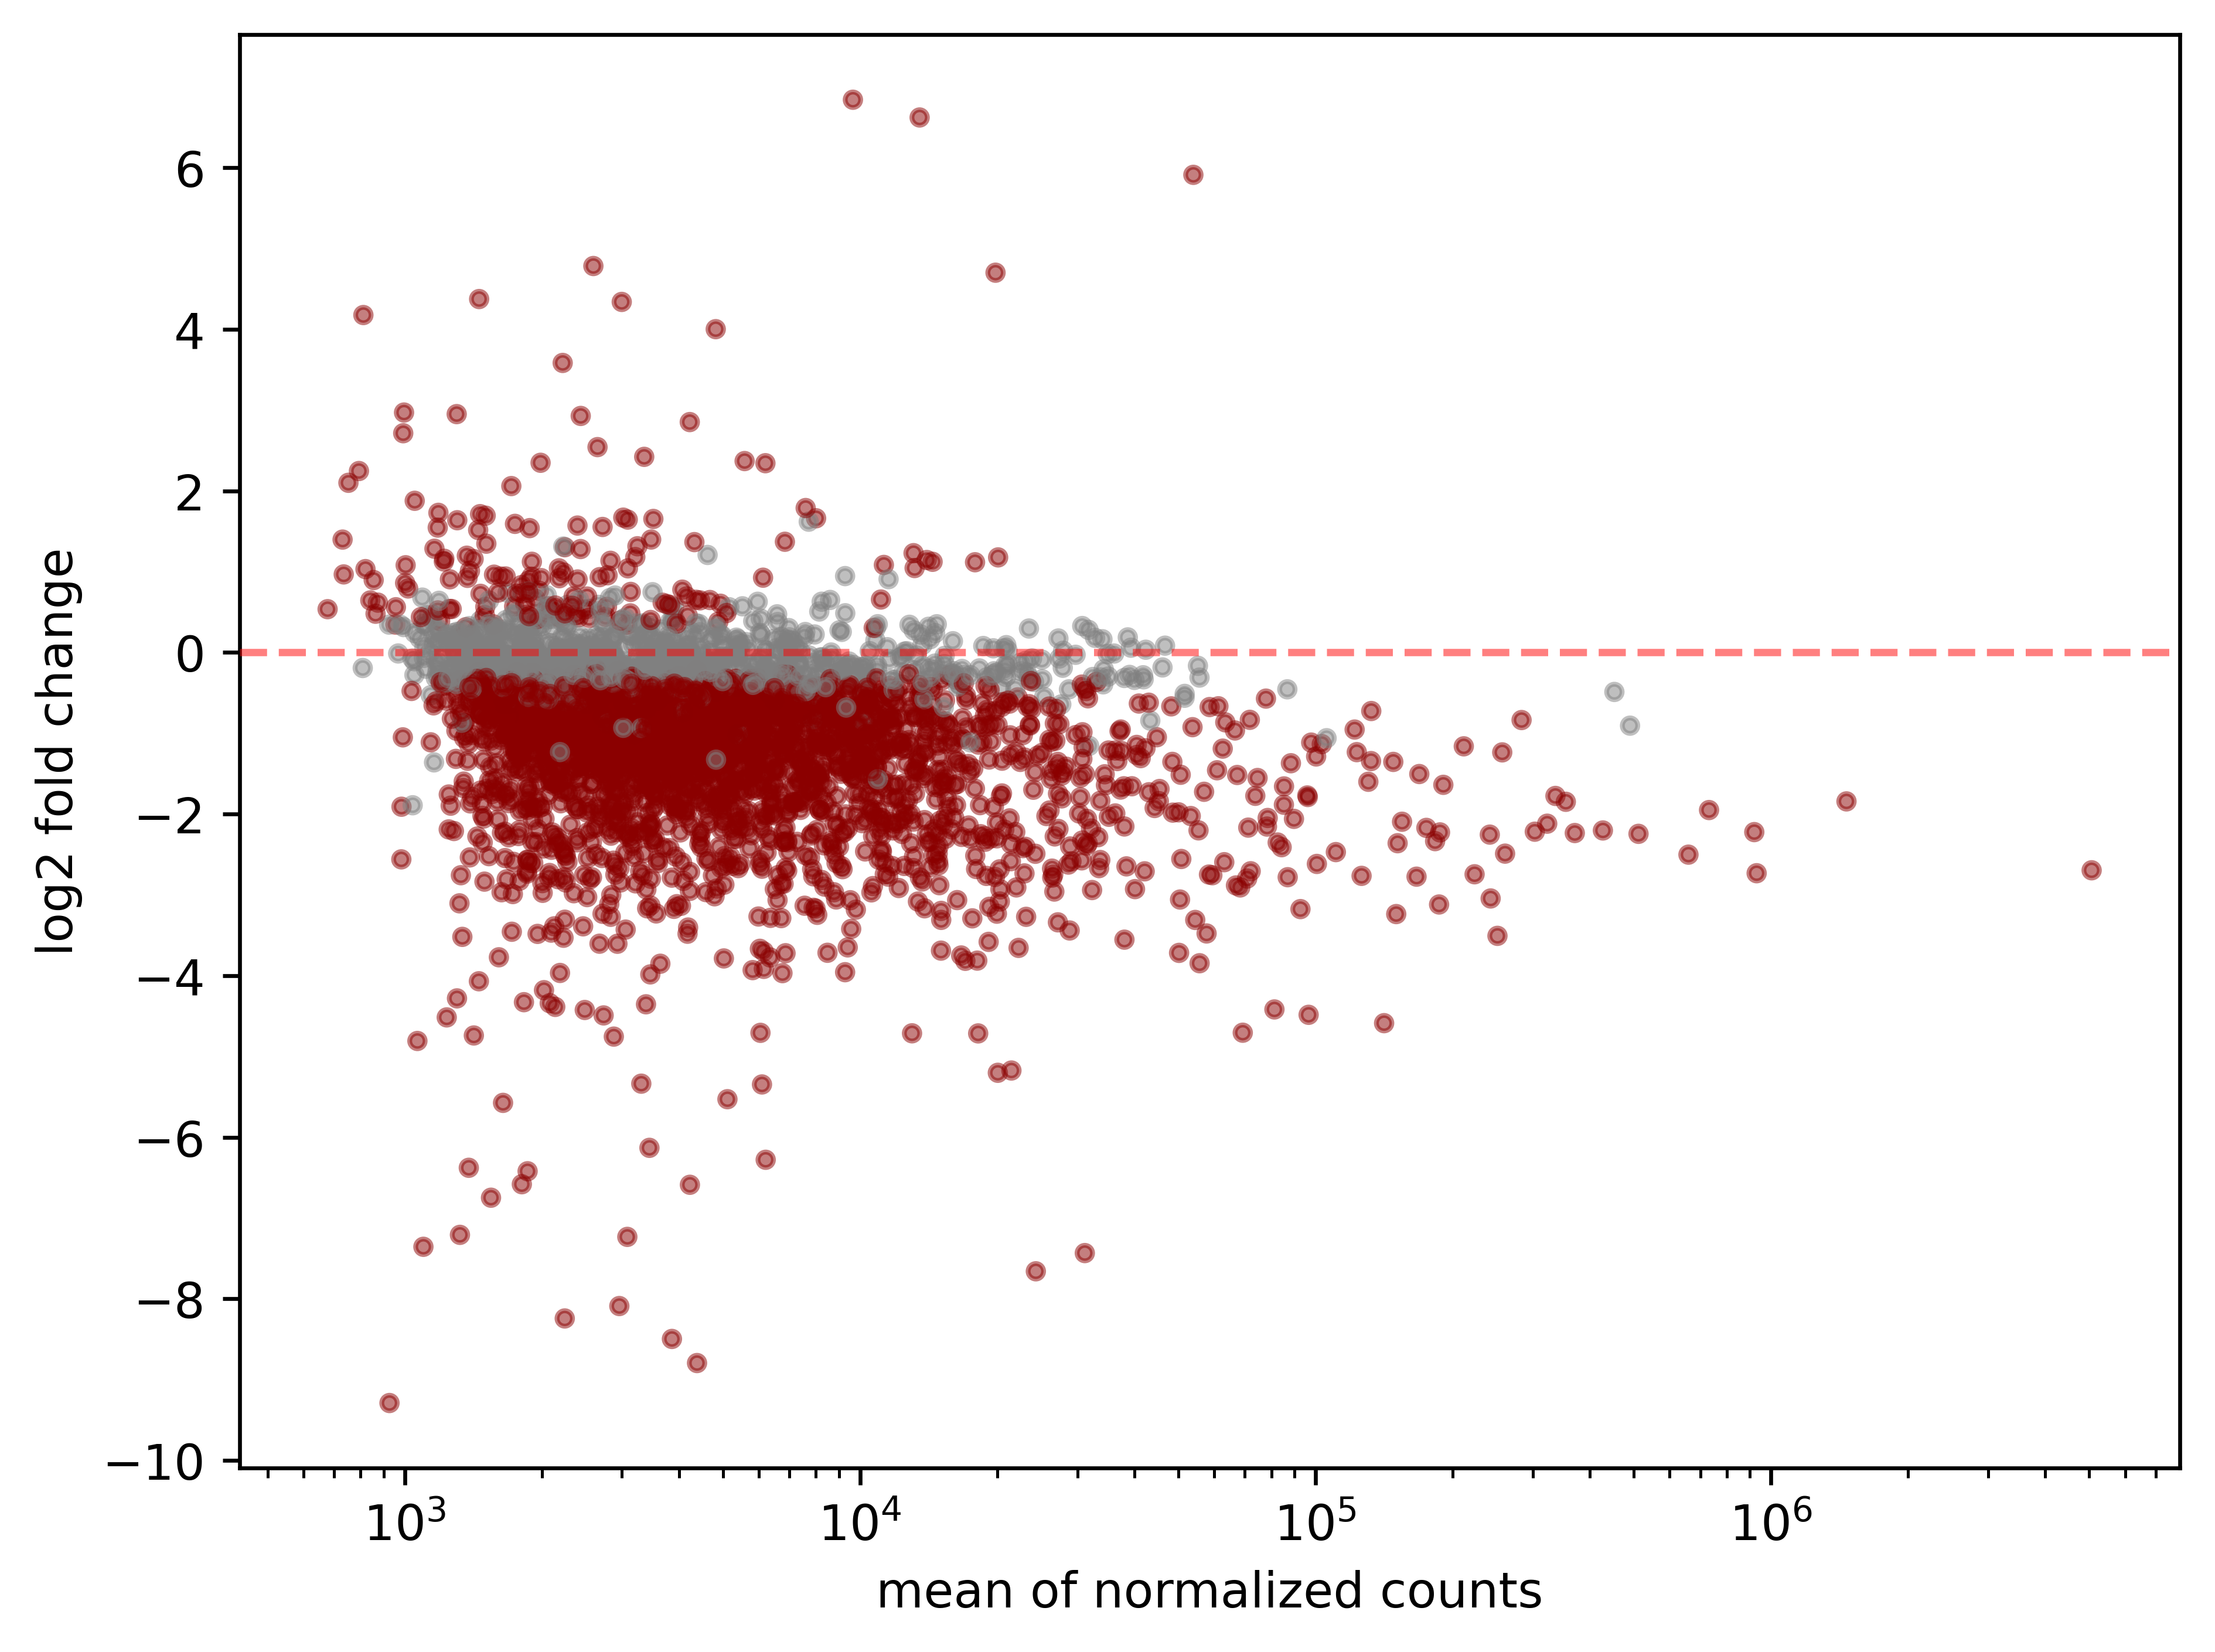

In [55]:
stat_res.plot_MA(s=10)

In [57]:
stat_res.lfc_shrink(coeff="condition_B_vs_A")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition B vs A
            baseMean  log2FoldChange     lfcSE      stat        pvalue  \
TSPAN6   5121.194686       -0.479644  0.220288 -2.348405  1.885400e-02   
CFH     78554.656981       -0.274285  0.395036 -5.265146  1.400779e-07   
FUCA2    2553.575428       -0.071847  0.175268 -0.540996  5.885100e-01   
GCLC     5090.402250       -1.638867  0.192812 -8.732665  2.487412e-18   
LAP3     8011.847162       -1.707931  0.199487 -8.391613  4.795186e-17   
...              ...             ...       ...       ...           ...   
SRD5A2   2097.342968       -3.286784  0.547090 -6.413663  1.420640e-10   
CISD3    4746.350367       -0.772401  0.223402 -3.711838  2.057599e-04   
MYO19     862.846821        0.464373  0.198293  2.397983  1.648563e-02   
ACACA    1851.904148        0.016253  0.222513  0.140494  8.882698e-01   
EBLN3P   1820.152214       -0.893803  0.192622 -4.727302  2.275227e-06   

                padj  
TSPAN6  2.634752e-02  
CFH

... done in 0.53 seconds.



In [59]:
stat_res.summary()

Log2 fold change & Wald test p-value: condition B vs A
            baseMean  log2FoldChange     lfcSE      stat        pvalue  \
TSPAN6   5121.194686       -0.479644  0.220288 -2.348405  1.885400e-02   
CFH     78554.656981       -0.274285  0.395036 -5.265146  1.400779e-07   
FUCA2    2553.575428       -0.071847  0.175268 -0.540996  5.885100e-01   
GCLC     5090.402250       -1.638867  0.192812 -8.732665  2.487412e-18   
LAP3     8011.847162       -1.707931  0.199487 -8.391613  4.795186e-17   
...              ...             ...       ...       ...           ...   
SRD5A2   2097.342968       -3.286784  0.547090 -6.413663  1.420640e-10   
CISD3    4746.350367       -0.772401  0.223402 -3.711838  2.057599e-04   
MYO19     862.846821        0.464373  0.198293  2.397983  1.648563e-02   
ACACA    1851.904148        0.016253  0.222513  0.140494  8.882698e-01   
EBLN3P   1820.152214       -0.893803  0.192622 -4.727302  2.275227e-06   

                padj  
TSPAN6  2.634752e-02  
CFH     3.

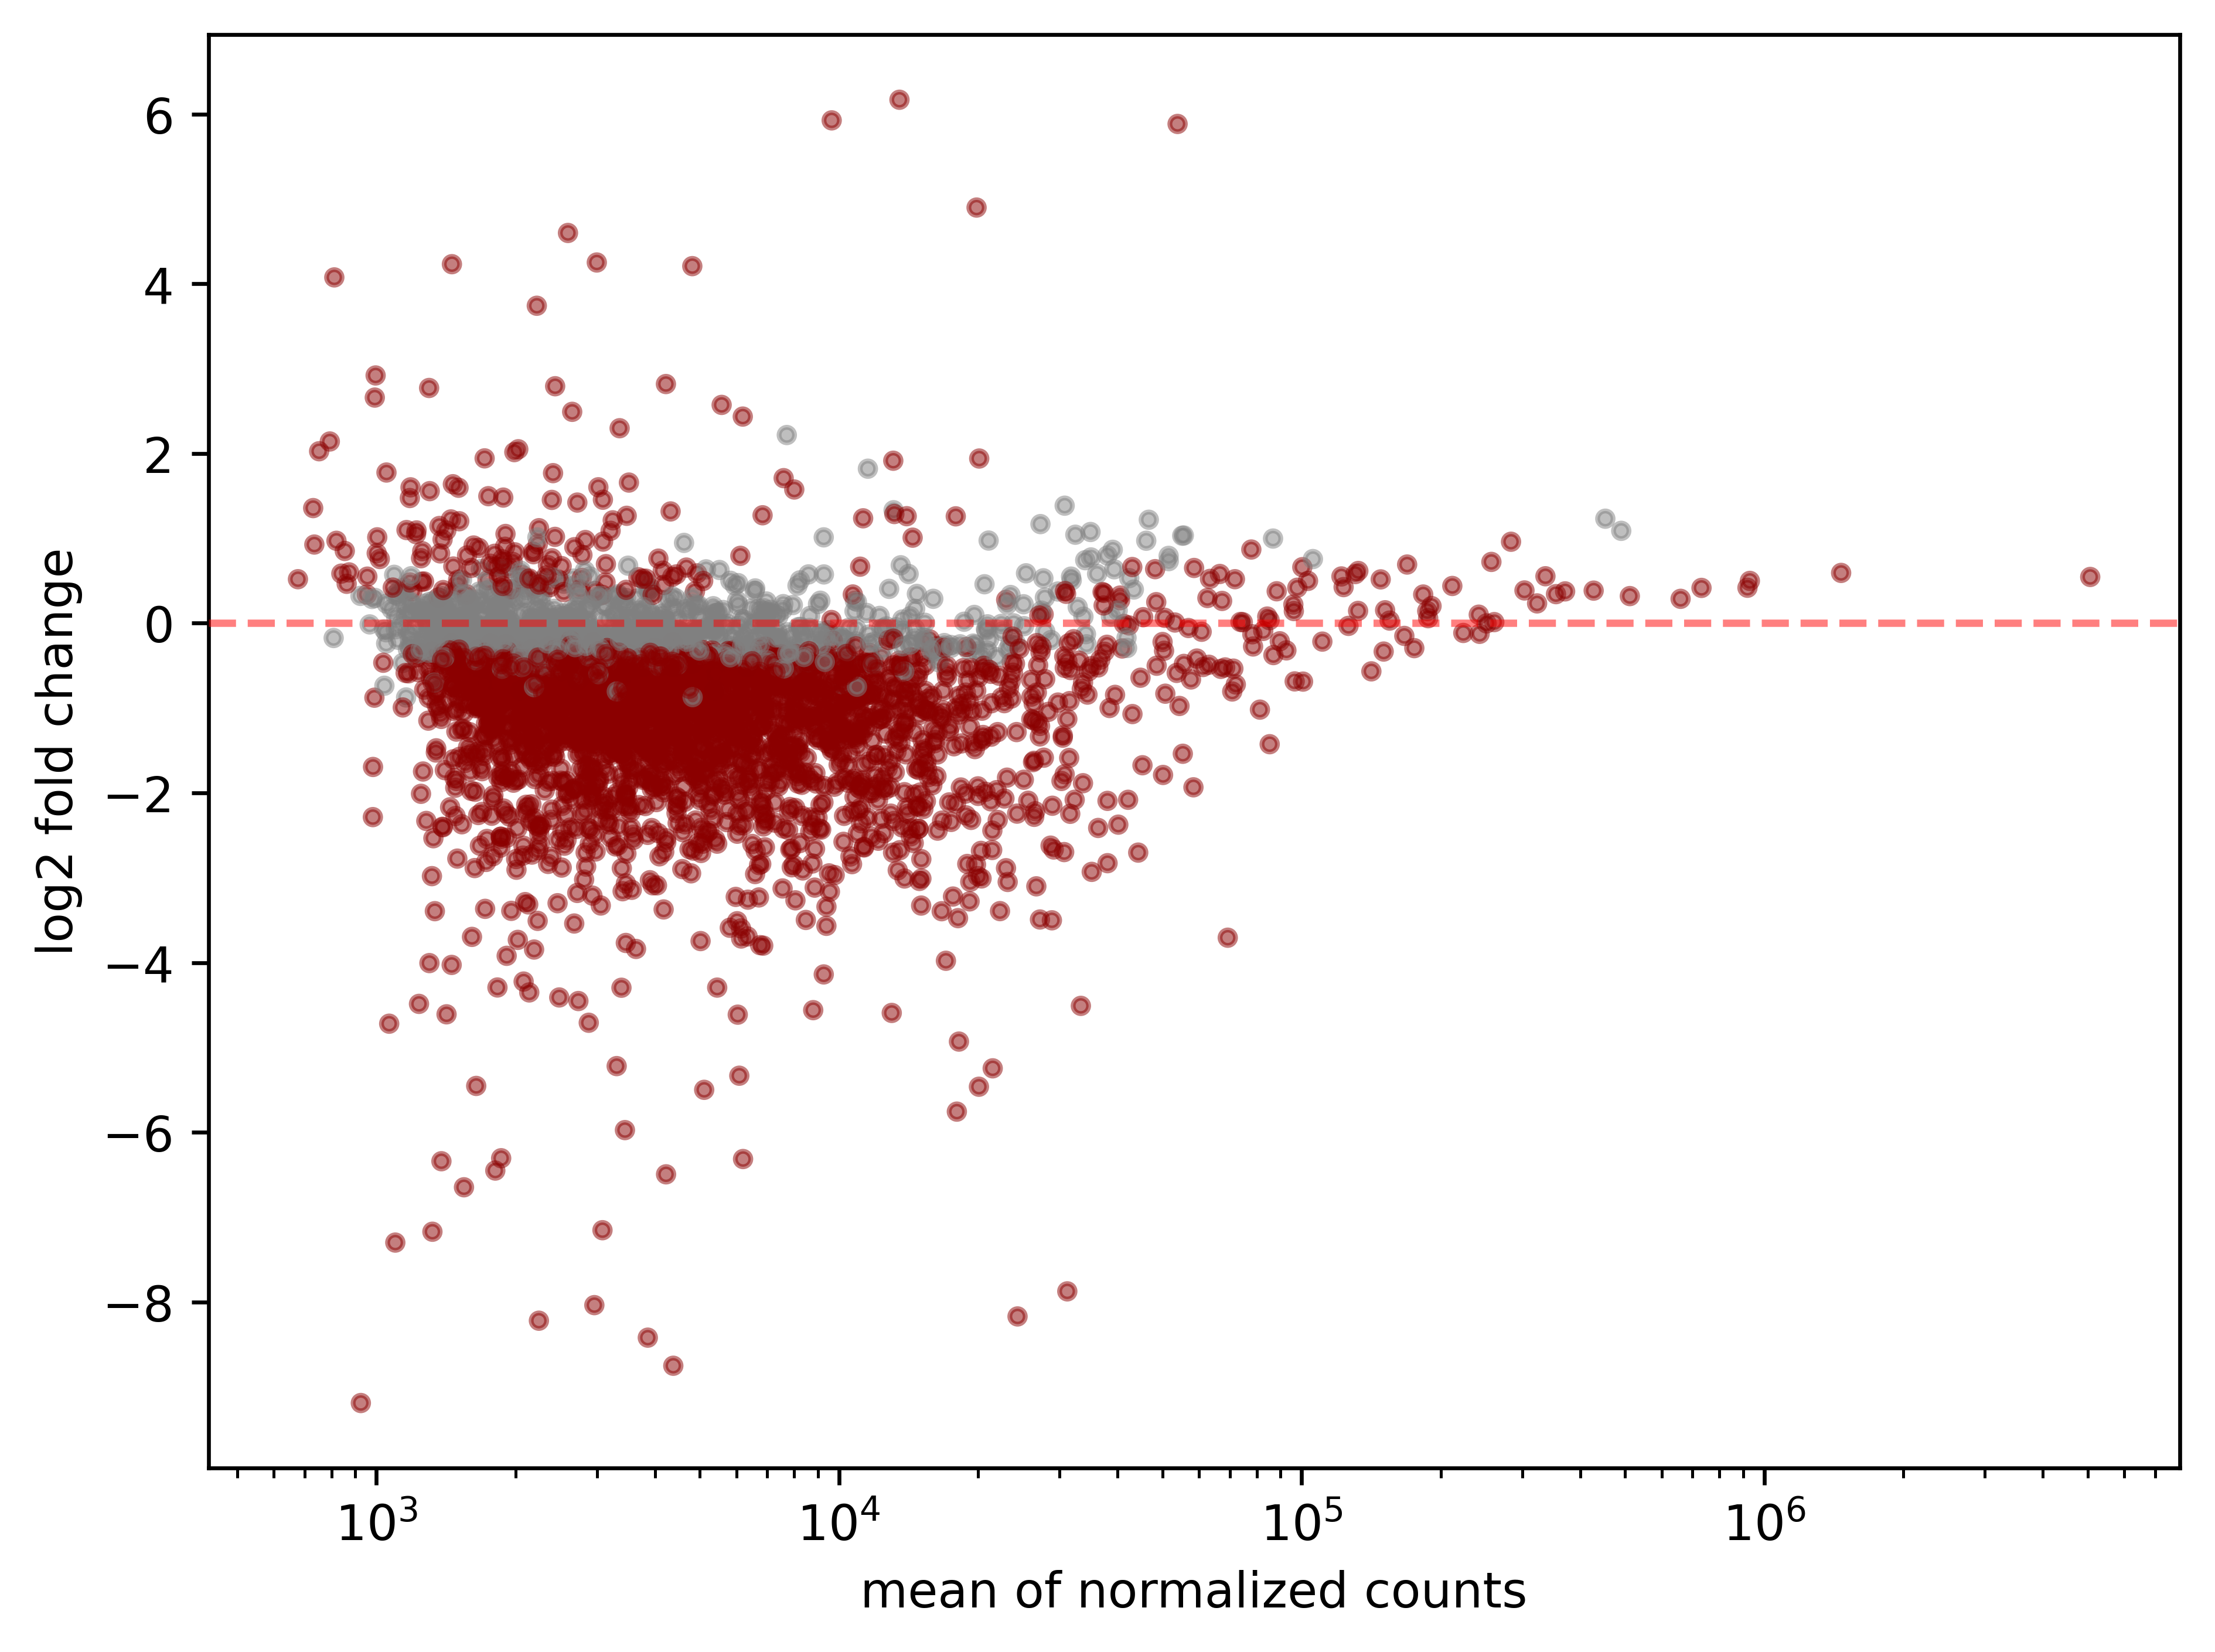

In [61]:
stat_res.plot_MA(s=10)

In [63]:
OUTPUT_PATH = "/Users/katsiarynadavydzenka/Documents/PhD_AI/CN-aware-DGE/Python/results/LIHC"
os.makedirs(OUTPUT_PATH, exist_ok=True)  # Create path if it doesn't exist
stat_res.results_df.to_csv(os.path.join(OUTPUT_PATH, "res_CNaware_test2.csv"))